\begin{alignat*}{2}
&\! \max_{q \succeq 0} & \qquad & \sum_j p(x_j) q(x_j) \mathbb{E}_y\left[ \log\left(1 + \frac{\lambda}{q(x_j)} \left( \theta - \rho(x_j, y, \beta) \right) \right) \right]  \\
& \text{subject to} & & \sum_j p(x_j) q(x_j) \leq c.
\end{alignat*}
Lower bound objective.
\begin{align}
& q(x_j) \mathbb{E}_y\left[ \log\left(1 + \frac{\lambda}{q(x_j)} \left( \theta - \rho(x_j, y, \beta) \right) \right) \right] \\
&\geq q(x_j) \mathbb{E}_y\left[ \frac{\lambda}{q(x_j)} \left( \theta - \rho(x_j, y, \beta) \right) - \frac{\psi(\lambda)}{q(x_j)^2} \left( \theta - \rho(x_j, y, \beta) \right)^2 \right] & \left( \psi(\lambda) \doteq -\lambda - \log(1 - \lambda) \right) \\
&= \lambda \left( \theta - \mathbb{E}_y\left[\rho(x_j, y, \beta)\right] \right) - \frac{1}{q(x_j)} \psi(\lambda) \mathbb{E}_y\left[\left( \theta - \rho(x_j, y, \beta) \right)^2 \right] 
\end{align}
Substitute
\begin{alignat*}{2}
&\! \min_{q \succeq 0} & \qquad & \sum_j \frac{p(x_j)}{q(x_j)} \psi(\lambda) \mathbb{E}_y\left[\left( \theta - \rho(x_j, y, \beta) \right)^2 \right]  \\
& \text{subject to} & & \sum_j p(x_j) q(x_j) \leq c.
\end{alignat*}
Substitute $\phi(x_j) \leftarrow p(x_j) q(x_j)$, 
\begin{alignat*}{2}
&\! \min_{q \succeq 0} & \qquad & \sum_j \frac{p^2(x_j)}{\phi(x_j)} \psi(\lambda) \mathbb{E}_y\left[\left( \theta - \rho(x_j, y, \beta) \right)^2 \right]  \\
& \text{subject to} & & \sum_j \phi(x_j) \leq c.
\end{alignat*}
This has solution $\phi(x_j) \propto p(x_j) \sqrt{\mathbb{E}_y\left[\left( \theta - \rho(x_j, y, \beta) \right)^2 \right]}$ which implies $q(x_j) \propto \sqrt{\mathbb{E}_y\left[\left( \theta - \rho(x_j, y, \beta) \right)^2 \right]}$.

**Simulation**: $y \sim \text{Bournelli}(x_j)$, $\rho$ is false positive rate, and $\beta$ is classifier threshold,  
\begin{align}
\rho(x_j, y, \beta) &= 1_{\beta \leq x_j} (1 - y) \\
\mathbb{E}_y\left[ \rho(x_j, y, \beta) \right] &= 1_{\beta \leq x_j} (1 - x_j) \\
\mathbb{E}_y\left[ \rho(x_j, y, \beta)^2 \right] &= 1_{\beta \leq x_j} (1 - x_j) \\
\mathbb{E}_y\left[\left( \theta - \rho(x_j, y, \beta) \right)^2 \right] &= \theta^2 + \left(1 -  2 \theta\right) 1_{\beta \leq x_j} (1 - x_j)
\end{align}
So we should anticipate
* When $\beta = 1$, sampling should be constant, since $1_{\beta \leq x_j} (1 - x_j)$ is zero everywhere.
* When $\beta < 1$ and $\theta < 1/2$, sampling should be
  * constant for $x_j < \beta$ since $1_{\beta \leq x_j} (1 - x_j)$ is zero in this regime, and
  * jump to a higher sampling rate it $x_j = \beta$ since $1_{\beta \leq x_j} (1 - x_j)$ is maximized at that point, and
  * sample at a decreasing rate as $x_j$ increases above $\beta$ since  $1_{\beta \leq x_j} (1 - x_j)$ is decreasing.


In [63]:
class LabellingPolicyPrimalPlayer(object):
    def __init__(self, *, policy, q_min, target_rate, theta, rho, opt, sched):
        from IwUpperMartingale import IwUpperMartingale
        
        assert 0 < q_min < target_rate < 1
        
        super().__init__()
        self._policy = policy
        self._q_min = q_min
        self._target_rate = target_rate
        self._theta = theta
        self._rho = rho
        self._opt = opt
        self._sched = sched

        self._iwmart = IwUpperMartingale(rho=rho, theta=theta, q_min=q_min, n_betas=1000, alpha=0.05)
        
    def predict(self, PX):
        import torch
        
        _, X = PX

        Q = self._q_min + (1 - self._q_min) * self._policy(X).squeeze(1)
        with torch.no_grad():
            cons = (self._target_rate - torch.mean(Q)).item()
        return Q, cons
        
    def update(self, PX, Q, dual):
        import torch
        
        P, X = PX

        # TODO: torch.mean or torch.sum (?)
        #       one component of the loss is over everything and the other is not

        loss = - dual * (self._target_rate - torch.mean(Q))
        
        with torch.no_grad():
            L = torch.bernoulli(Q)
            
        if torch.any(L == 1):
            # TODO: can we clip curlam after observing q_min for this batch, but before observing rho?
            #       b/c then we could handle Q > 0 without an explicit minimum
            #       i think it's ok b/c conditioned on x the mean is still correct and then tower property
            
            curlam = self._iwmart.getlam()
            curbeta, _ = self._iwmart.getbeta()
            Qsamp = Q[L == 1]
            Xsamp = X[L == 1,:]
            Psamp = P[L == 1]
            with torch.no_grad():
                Xsampnumpy = Xsamp.numpy()
                Ysamp = self._rho.realize((Psamp, Xsampnumpy))
                PXYsamp = ((Psamp, Xsampnumpy), Ysamp)
                rhosamp = torch.Tensor(self._rho(PXYsamp, curbeta))
            f = torch.log1p(curlam * (self._theta - rhosamp) / Qsamp)
            stopf = f.detach()
            loss -= (torch.log(Qsamp) * stopf + f).mean()
            
            # update betting martingale
            with torch.no_grad():
                for qi, pi, xi, yi in zip(Qsamp, Psamp, Xsampnumpy, Ysamp):
                    self._iwmart.addobs(qi.item(), ((pi, xi), yi))
            
        self._opt.zero_grad()
        loss.backward()
        self._opt.step()
        self._sched.step()

betastar = 0.683772233983162
n    	 bet       	 beta      	 p                                                           	 Q(p)                                                        	 cons      	 dual      	
    0	 1.250e-02	 1.000e+00	 [0.00 0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 1.00]	 [0.50 0.49 0.48 0.52 0.53 0.50 0.51 0.52 0.54 0.50 0.50]	 -3.086e-01	 3.069e-01	
    1	 1.250e-02	 1.000e+00	 [0.00 0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 1.00]	 [0.50 0.48 0.48 0.51 0.53 0.50 0.51 0.51 0.54 0.50 0.50]	 -3.062e-01	 3.069e-01	
    2	 1.250e-02	 1.000e+00	 [0.00 0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 1.00]	 [0.50 0.48 0.48 0.51 0.53 0.49 0.51 0.51 0.54 0.50 0.50]	 -3.038e-01	 3.069e-01	
    4	 1.250e-02	 1.000e+00	 [0.00 0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 1.00]	 [0.49 0.48 0.47 0.51 0.52 0.49 0.50 0.51 0.53 0.49 0.49]	 -2.991e-01	 3.069e-01	
    8	 1.250e-02	 1.000e+00	 [0.00 0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 1.00]	 [0.48 0.47 0.46 0.50 0.51 0.48 0.

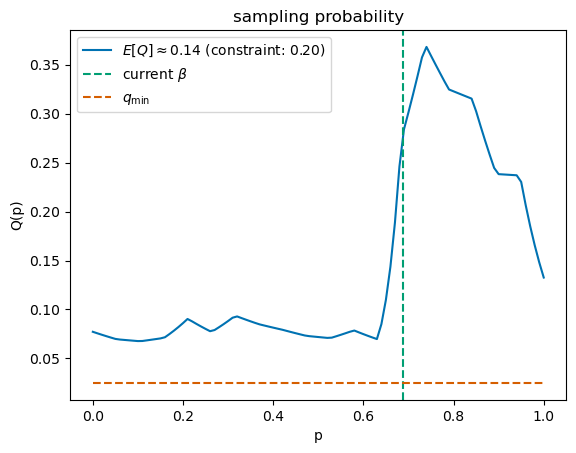

In [114]:
def test_once(seed):
    from IwUpperMartingale import IwUpperMartingale
    from OnlineMinimax import OnlineMinimax, BestResponse, BeTheLeader
    from LogisticRegression import LogisticRegressor

    import numpy as np
    import torch

    gen = np.random.default_rng(seed)
    torch.manual_seed(seed+1)
    
    np.set_printoptions(2, floatmode='fixed')
    
    class FalsePositive(object):
        def __init__(self):
            super().__init__()

        def __call__(self, PXY, betas):
            (P, _), Y = PXY
            return (betas <= P) * (1 - Y)

        def realize(self, PX):
            P, _ = PX
            return gen.binomial(1, P)
        
    knots = np.linspace(0, 1, 20)
    def featurize(p):
        rv = [0]*len(knots)

        if p >= knots[-1]:
            rv[-1] = 1
        else:
            z = np.digitize(p, knots)
            vlow, vhigh = knots[z-1], knots[z]
            frac = (p - vlow) / (vhigh - vlow)
            rv[z] = frac
            rv[z - 1] = 1 - frac
            
        return rv

    policy = LogisticRegressor(in_features=len(featurize(0.1)), out_features=1)
    q_min = 1/40
    target_rate = 1/5
    theta = 1/20
    betastar = 1 - np.sqrt(2 * theta)
    print(f'betastar = {betastar}')
    rho = FalsePositive()
    opt = torch.optim.Adam(policy.parameters(), lr=5e-3)
    sched = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda t:1) # (1+t/1000)**(-0.5))

    primal_player = LabellingPolicyPrimalPlayer(policy=policy, 
                                                q_min=q_min,
                                                target_rate=target_rate,
                                                theta=theta,
                                                rho=rho,
                                                opt=opt,
                                                sched=sched)
    # anything bigger than (1 - Log[2]) should be good enough for max_dual
    dual_player = BestResponse(max_dual=1 - np.log(2))
    # TODO: windowed be the leader, batching with best response
    minimax = OnlineMinimax(primal_player=primal_player, dual_player=dual_player)

    print(f'{"n":5s}\t', f'{"bet":10s}\t', f'{"beta":10s}\t', f'{"p":60s}\t', f'{"Q(p)":60s}\t', f'{"cons":10s}\t', f'{"dual":10s}\t')
    batch_size = 64
    for n in range(1 + (1 << 15)):
        p = gen.uniform(size=batch_size)
        X = torch.Tensor([featurize(z) for z in p])
        minimax.addobs((p, X))
        if n & (n - 1) == 0:
            with torch.no_grad():
                p = np.linspace(0, 1, 11)
                X = torch.Tensor([ featurize(z) for z in p ])
                Q, cons = primal_player.predict((p, X))
                dual = dual_player.predict(peek=-cons)
                lam = primal_player._iwmart.getlam()
                beta, _ = primal_player._iwmart.getbeta()
                print(f'{n:5d}\t', f'{lam:.03e}\t', f'{beta:.03e}\t', f'{p}\t', f'{Q.numpy()}\t', f'{cons:.3e}\t', f'{dual:.3e}\t')
                
    with torch.no_grad():
        import matplotlib.pyplot as plt 
        with plt.style.context("seaborn-colorblind"):
            p = p = np.linspace(0, 1, 101)
            X = torch.Tensor([ featurize(z) for z in p ])
            Q, cons = primal_player.predict((p, X))
            plt.plot(p, Q.numpy(), label=f'$E[Q] \\approx {torch.mean(Q).item():.2f}$ (constraint: {target_rate:.2f})')
            vline_color = next(plt.gca()._get_lines.prop_cycler)['color']
            plt.axvline(x=primal_player._iwmart.getbeta()[0], label='current $\\beta$', linestyle='dashed', color=vline_color)
            plt.plot(p, [q_min]*len(p), label='$q_\\min$', linestyle='dashed')
            plt.xlabel('p')
            plt.ylabel('Q(p)')
            plt.title('sampling probability')
            plt.legend()
    
def test():
    test_once(seed=9)

test()